## Random Forest Playground
This code references [this tutorial](https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/) on AV. Also, this on [medium](https://towardsdatascience.com/random-forest-ca80e56224c1).

some findings:
- when splitting by zero fatalities / one or more fatalities, the dataset was split almost exactly 50-50. the oob score was around 0.63 and the best oob score was with (max_depth=20, min_samples_leaf=10, n_estimators=200), which achieved a oob score of 0.645.
- when splitting by less than 10 / 10 or more fatalities, the dataset was split 92-8, basically. oob score was about 0.9212, which is the same as guessing. best was 0.9219 with (max_depth=10, min_samples_leaf=5, n_estimators=30)

In [21]:
# Importing the required libraries
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

### read and clean data

In [75]:
df = pd.read_csv("../data/acled/darfur.csv")
df.columns

selected_columns = ['LATITUDE', 'LONGITUDE', 'FATALITIES', 'TIMESTAMP']
df_short = df[selected_columns].copy()
print(df_short.head())

   LATITUDE  LONGITUDE  FATALITIES   TIMESTAMP
0     9.616     27.499           2  1687837306
1     9.616     27.499          11  1673906973
2     9.604     27.734          15  1649110873
3     9.616     27.499           5  1673906973
4     9.616     27.499           1  1673906973


In [24]:
df_short['FATAL'] = (df_short['FATALITIES'] > 5).astype(int)
df_short['FATAL'].value_counts()

FATAL
0    8123
1    1193
Name: count, dtype: int64

In [25]:
cleaned = df_short.drop(['FATALITIES'], axis=1)
cleaned.head()

,LATITUDE,LONGITUDE,TIMESTAMP,FATAL
0,9.616,27.499,1687837306,0
1,9.616,27.499,1673906973,1
2,9.604,27.734,1649110873,1
3,9.616,27.499,1673906973,0
4,9.616,27.499,1673906973,0


In [26]:
X = cleaned.drop('FATAL',axis=1)
y = cleaned['FATAL']

In [27]:
# Splitting the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_train.shape, X_test.shape

((6521, 3), (2795, 3))

### train the random forest classifier

In [28]:
from sklearn.ensemble import RandomForestClassifier

classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True, class_weight='balanced_subsample') # class_weight='balanced_subsample'

%time
classifier_rf.fit(X_train, y_train)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 182 µs


RandomForestClassifier(class_weight='balanced_subsample', max_depth=5,
                       n_jobs=-1, oob_score=True, random_state=42)

In [29]:
# https://www.analyticsvidhya.com/blog/2022/11/out-of-bag-oob-score-for-bagging-in-data-science/#:~:text=The%20prediction%20error%20on%20that,score%20for%20the%20bottom%20model.

# Out of Bag Error
classifier_rf.oob_score_


0.6948320809691765

In [42]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

skip_gs = True
rf_best = RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       min_samples_leaf=5, n_estimators=200, n_jobs=-1, oob_score=True,
                       random_state=42)
rf_best.fit(X_train, y_train)
print(rf_best.oob_score_)

params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

# params = {
#     'max_depth': [5,11,13,15,20], # 20 // 15
#     'min_samples_leaf': [1,2,3,4,5], # 5 // 2
#     'n_estimators': [30,35,40,45] # 30 // 35
# }

from sklearn.model_selection import GridSearchCV

# Instantiate the grid search model
if not skip_gs:
    grid_search = GridSearchCV(estimator=rf,
                            param_grid=params,
                            cv = 4,
                            n_jobs=-1, verbose=1, scoring="accuracy")

    %time
    grid_search.fit(X_train, y_train)

0.7544855083576139


In [32]:
grid_search.best_score_

AttributeError: 'RandomForestClassifier' object has no attribute 'best_score_'

In [53]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=5, n_estimators=200, n_jobs=-1,
                       random_state=42)

### visualize the results

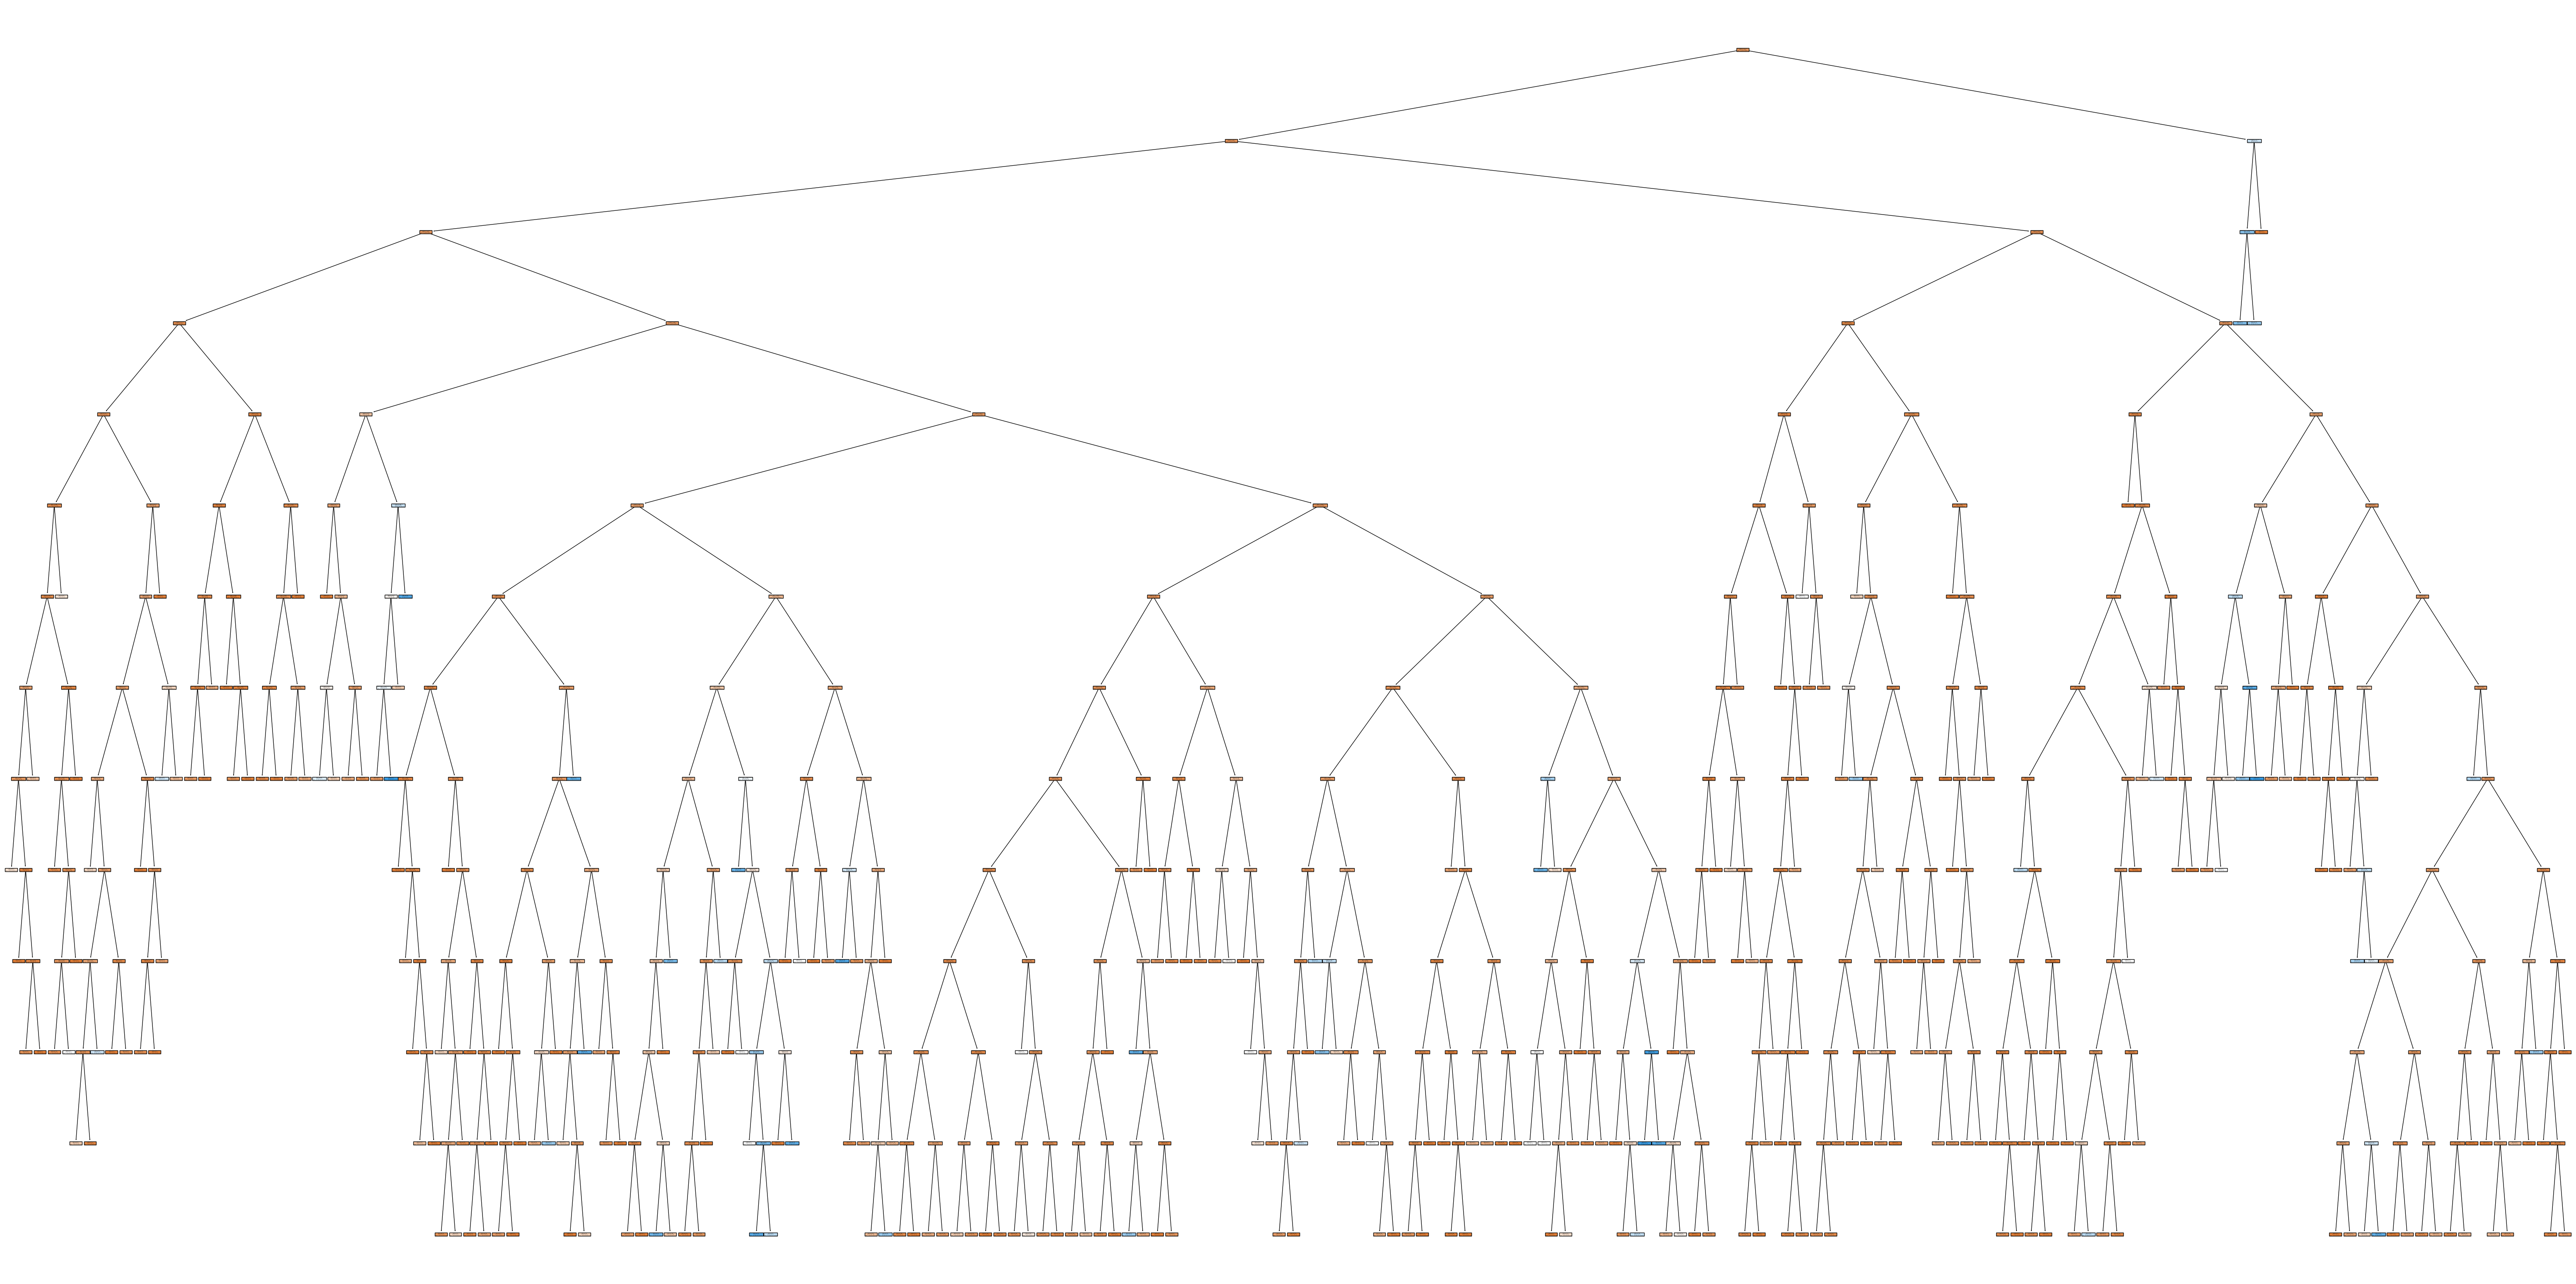

In [48]:
from sklearn.tree import plot_tree

plt.figure(figsize=(80,40))
plot_tree(rf_best.estimators_[5], feature_names = X.columns,class_names=['Fatalities Reported', "No Fatalities Reported"],filled=True);

In [40]:
imp_df = pd.DataFrame({
    "variable name": X_train.columns,
    "importance": rf_best.feature_importances_ # this is using the mean decrease in gini score
})

imp_df.sort_values(by="importance", ascending=False)

,variable name,importance
2,TIMESTAMP,0.436715
1,LONGITUDE,0.290286
0,LATITUDE,0.272999


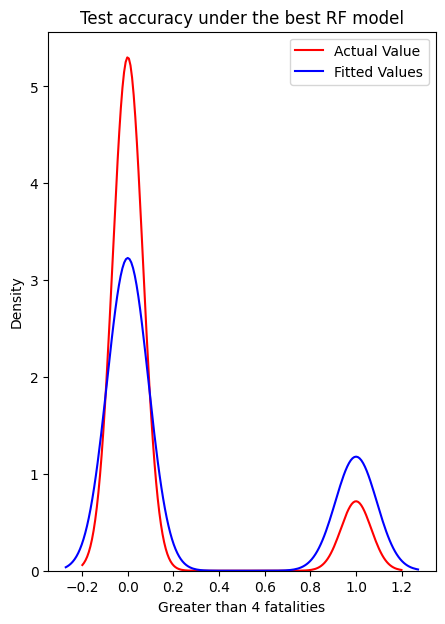

In [43]:
import seaborn as sns
current_rf = rf_best
y_pred = current_rf.predict(X_test)

plt.figure(figsize=(5, 7))
# Plotting actual values
sns.kdeplot(y_test, color="r", label="Actual Value")
# Plotting predicted values
sns.kdeplot(y_pred, color="b", label="Fitted Values")

plt.legend()
plt.title("Test accuracy under the best RF model")
plt.xlabel("Greater than 4 fatalities")
plt.show()

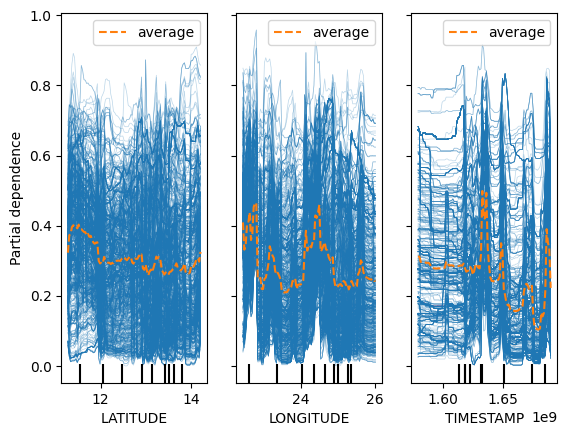

In [60]:
## partial dependence plots

from sklearn.inspection import PartialDependenceDisplay
# PartialDependenceDisplay.from_estimator(rf_best, X, [0,1,2], kind='')

features = [0, 1, 2]
PartialDependenceDisplay.from_estimator(rf_best, X_train, features, kind='both')



      LATITUDE  LONGITUDE   TIMESTAMP  y_true  y_pred
1512    13.441     22.445  1674517872       0       0
8853    13.626     25.356  1636413266       0       1
9266    13.626     25.356  1632239615       1       1
960     13.626     25.356  1681225751       0       0
8114    13.626     25.356  1632239614       0       1


Separation plot of example separation plot for darfur predictions.

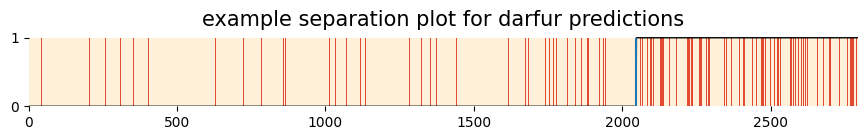

In [71]:
import sepplotlib as spl
## package documentation here: https://pypi.org/project/sepplotlib/
## originally by greenhill et al, a conflicts researcher

df = X_test.copy()
df['y_true'] = list(y_test.values)
df['y_pred'] = y_pred
print(df.head())

spl.SeparationPlot(
    df=df,
    y_true="y_true",
    y_pred="y_pred",
    title="example separation plot for darfur predictions"
)

In [73]:
import sklearn.metrics as metrics
metrics.roc_curve(df['y_true'], df['y_pred'])

(array([0.        , 0.22014622, 1.        ]),
 array([0.        , 0.61561562, 1.        ]),
 array([inf,  1.,  0.]))

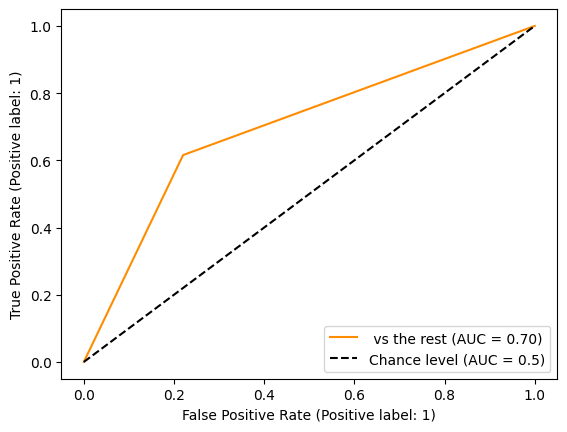

In [74]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    df['y_true'],
    df['y_pred'],
    name=f" vs the rest",
    color="darkorange",
    plot_chance_level=True,
)

## prediction across different regions

shapefiles taken from princeton repository [here](https://maps.princeton.edu/catalog/stanford-jz673tr4443)


In [95]:
df = X_test.copy()
df['y_true'] = list(y_test.values)
df['y_pred'] = y_pred
df['correct'] = (df['y_true'] == df['y_pred']).astype(int)
df.head()

,LATITUDE,LONGITUDE,TIMESTAMP,y_true,y_pred,correct
1183,11.948,32.106,1650317298,1,1,1
1038,8.409,30.186,1665519451,0,0,1
9215,8.042,32.029,1675727772,1,1,1
908,7.906,31.890,1681248787,0,1,0
8490,4.855,31.580,1620691975,0,0,1


In [90]:
import geopandas as gpd
# Replace with the path to your shapefile
shapefile_path = '../data/shapefiles/stanford-jz673tr4443-shapefile/jz673tr4443.shp'

# Read the shapefile
ss_shp = gpd.read_file(shapefile_path)

# Now you can work with 'gdf' as a GeoDataFrame
print(ss_shp.head())

    id_0  iso       name_0  id_1             name_1  id_2         name_2  \
0  214.0  SSD  South Sudan   1.0  Central Equatoria   1.0  Bahr al Jabal   
1  214.0  SSD  South Sudan   1.0  Central Equatoria   2.0      Kajo Kaii   
2  214.0  SSD  South Sudan   1.0  Central Equatoria   3.0       Nahr Yei   
3  214.0  SSD  South Sudan   1.0  Central Equatoria   4.0        Terkaka   
4  214.0  SSD  South Sudan   2.0  Eastern Equatoria   5.0       Amatonge   

   id_3    name_3  ccn_3 cca_3   type_3 engtype_3 nl_name_3 varname_3  \
0   1.0      Juba    0.0  None  Unknown   Unknown      None      None   
1   2.0  Kajikaji    0.0  None  Unknown   Unknown      None      None   
2   3.0       Yei    0.0  None  Unknown   Unknown      None      None   
3   4.0  Treikaka    0.0  None  Unknown   Unknown      None      None   
4   5.0   Akotous    0.0  None  Unknown   Unknown      None      None   

                                            geometry  
0  POLYGON ((32.21575 4.59746, 32.17772 4.55581, 

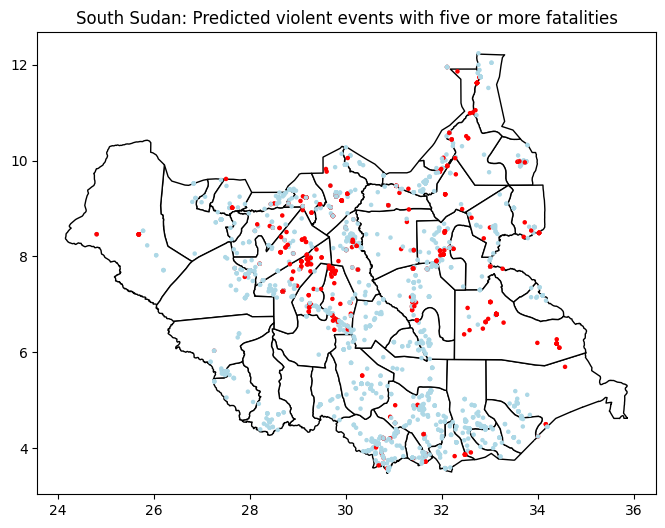

In [105]:
import geopandas as gpd
import matplotlib.pyplot as plt

## grab coordinates
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['LONGITUDE'], df['LATITUDE']))
fig, ax = plt.subplots(figsize=(10, 6))
gdf['color'] = gdf['y_pred'].apply(lambda x: 'red' if x else 'lightblue')

# Plot country borders
ss_shp.plot(ax=ax, color='white', edgecolor='black')

# Plot your data with two colors based on the 'color' column
gdf.plot(ax=ax, marker='o', color=gdf['color'], markersize=5)

plt.title("South Sudan: Predicted violent events with five or more fatalities")
plt.show()

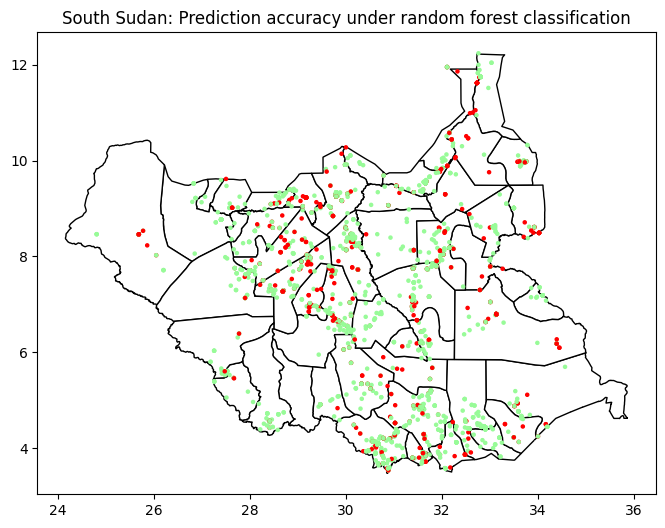

In [104]:
import geopandas as gpd
import matplotlib.pyplot as plt

## grab coordinates
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['LONGITUDE'], df['LATITUDE']))
fig, ax = plt.subplots(figsize=(10, 6))
gdf['correct_color'] = gdf['correct'].apply(lambda x: 'palegreen' if x else 'red')

# Plot country borders
ss_shp.plot(ax=ax, color='white', edgecolor='black')

# Plot your data with two colors based on the 'color' column
gdf.plot(ax=ax, marker='o', color=gdf['correct_color'], markersize=5)

plt.title("South Sudan: Prediction accuracy under random forest classification")
plt.show()